### Challenge 06 - Store Sales: Time Series Forecasting

1. Data Loading
2. Feature Engineering
3. Lag + Rolling Features
4. External data enrichment
5. Train/Validation Split
6. Model Training + Validation
7. Feature Importance
8. Generate Predictions

In [212]:
# 0. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, plot_importance
from sklearn.metrics import mean_squared_log_error

### 1. Data Loading

In [213]:
df = pd.read_csv("../data/store-sales-time-series-forecasting/train.csv")
holidays = pd.read_csv("../data/store-sales-time-series-forecasting/holidays_events.csv")
transactions = pd.read_csv("../data/store-sales-time-series-forecasting/transactions.csv")
stores = pd.read_csv('../data/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('../data/store-sales-time-series-forecasting/oil.csv')
test = pd.read_csv("../data/store-sales-time-series-forecasting/test.csv")

### 2. Date, Promotion, and Holiday Features

In [214]:
df['date'] = pd.to_datetime(df['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
test['date'] = pd.to_datetime(test['date'])

In [215]:
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
df['is_weekend'] = df['day_of_week'].isin([5, 6])
df['is_new_year'] = (df['date'].dt.month == 1) & (df['date'].dt.day == 1)
df['is_december'] = df['month'] == 12

In [216]:
# Merge holiday data
df = df.merge(holidays[['date', 'type']], on='date', how='left')
df['is_holiday'] = df['type'].notna()
df.drop(columns=['type'], inplace=True)

#### Daily sales

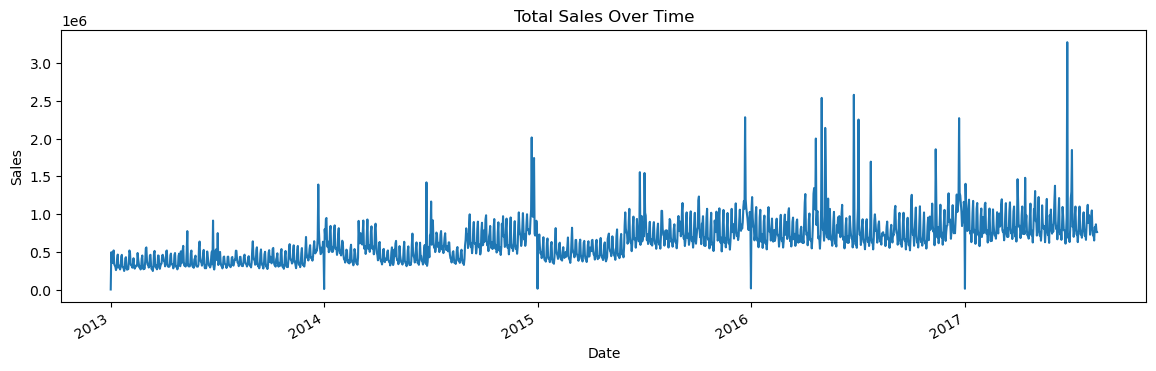

In [217]:
# Plot sales trend
sales_trend = df.groupby('date')['sales'].sum()
sales_trend.plot(title='Total Sales Over Time', figsize=(14, 4))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Graph above shows:
- Sales increase year over year — this is a global growth signal.
- Those deep vertical drops almost to zero are likely holidays or closures.
- Sales get especially high in late-year periods — likely holiday season.

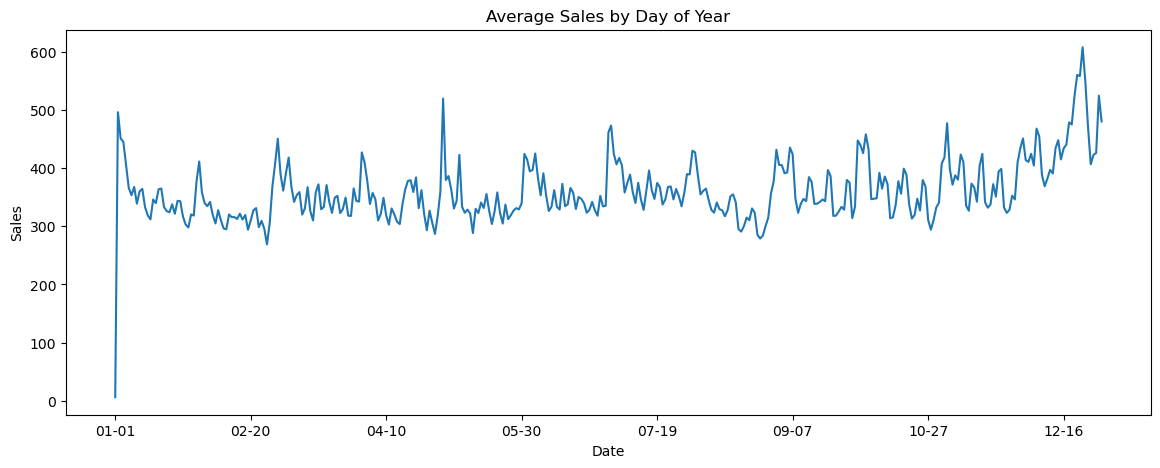

In [218]:
df['day_month'] = df['date'].dt.strftime('%m-%d')
pivot = df.groupby(['day_month'])['sales'].mean()
pivot.plot(figsize=(14,5), title='Average Sales by Day of Year')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Graph above shows:
- Jan 1 dip
    - Clearly visible and dramatic — probably zero sales that day.
    - Definitely include a is_new_year feature or even consider excluding that row when calculating moving averages.
- Rising trend in December
    - Strong upward slope starting mid-November — classic holiday sales ramp-up.
    - Suggests a feature like is_holiday_season = date >= Nov 15
- Spikes mid-year
    - These could correspond to local holidays or promotional events. To be investigated using the holidays_events.csv file.

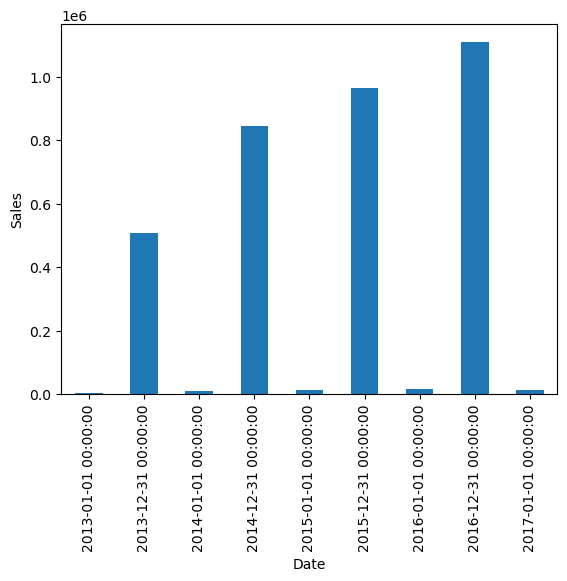

In [219]:
df[df['date'].dt.strftime('%m-%d').isin(['12-31', '01-01'])].groupby('date')['sales'].sum().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Graph above shows:
- Spikes on Dec 31: Could be customers stocking up, end-of-year clearance, or final day of promos.
- Zero or near-zero on Jan 1: Store closures or minimal operations.

#### Sales per store

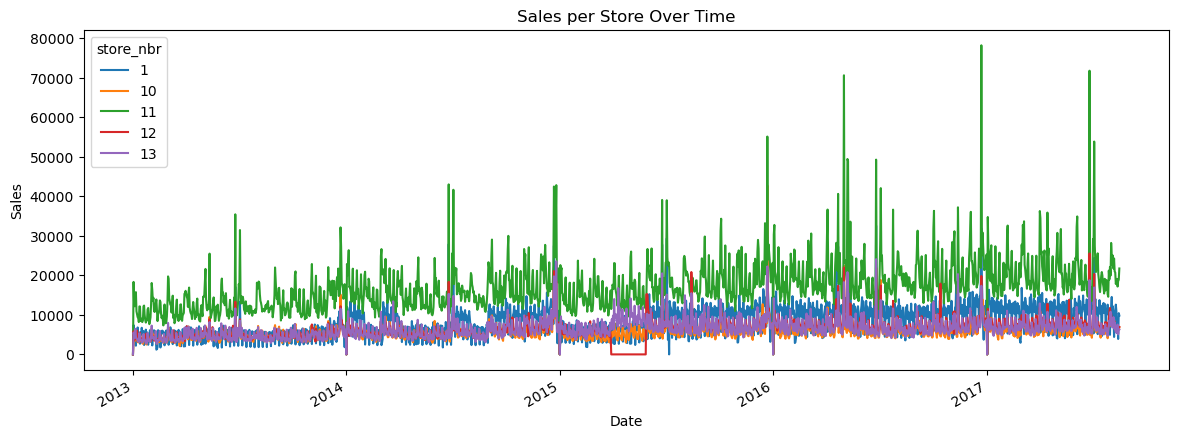

In [220]:
sample_stores = df['store_nbr'].unique()[:5]  # or use np.random.choice()
df_per_store = df.groupby(['date','store_nbr'])['sales'].sum().unstack()[sample_stores]
df_per_store.plot(figsize=(14, 5), title='Sales per Store Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Graph above shows:
- Store 11 has consistently higher sales → possibly a flagship or high-traffic location.
- Other stores follow similar patterns, just with lower magnitude. It means the sales shape is learnable, and the model can generalise across stores if store ID is included as a feature.

#### Sales per family

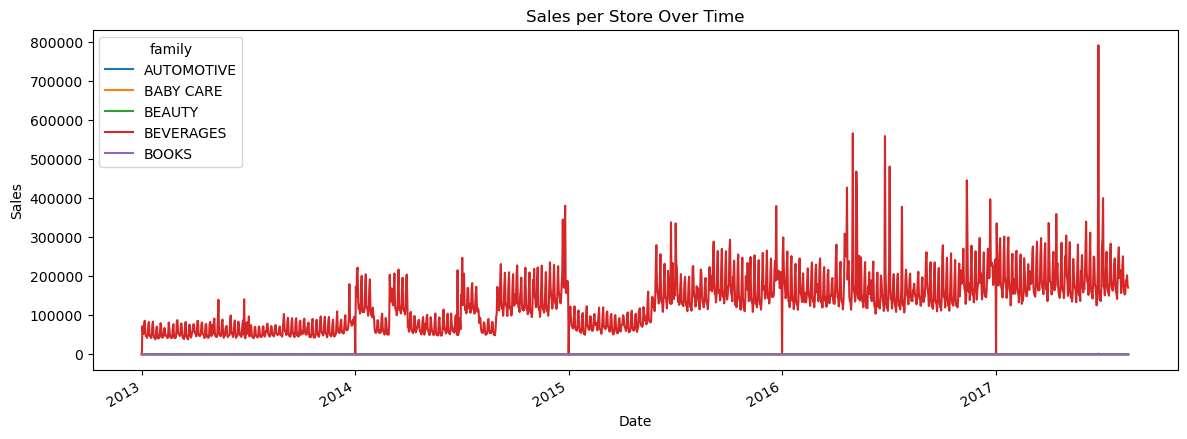

In [221]:
sample_stores = df['family'].unique()[:5]
df_per_store = df.groupby(['date','family'])['sales'].sum().unstack()[sample_stores]
df_per_store.plot(figsize=(14, 5), title='Sales per Store Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Graph above shows: 
- Beverages dominate sales volume by a large margin
- Other families (like Books, Automotive) have very low or flat sales, could be sparse or seasonal.

#### Datetime features (day, month, etc.)

In [222]:
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6])
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
df['is_new_year'] = (df['date'].dt.month == 1) & (df['date'].dt.day == 1)
df['is_year_end'] = (df['date'].dt.month == 12) & (df['date'].dt.day == 31)
df['is_december'] = df['month'] == 12
df['is_holiday_season'] = df['date'].dt.month.isin([11, 12])

#### Holiday events addition

In [223]:
df = df.merge(holidays, on='date', how='left')

In [224]:
print(len(df))

3186216


In [225]:
df['is_holiday'] = df['type'].notna()
df['holiday_type'] = df['type'].fillna('None')

In [226]:
df[df['is_holiday']].sort_values('date').head()

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,year,week_of_year,...,is_holiday,day_month,is_year_end,is_holiday_season,type,locale,locale_name,description,transferred,holiday_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,1,...,True,01-01,False,False,Holiday,National,Ecuador,Primer dia del ano,False,Holiday
1194,1194,2013-01-01,42,CELEBRATION,0.0,0,1,1,2013,1,...,True,01-01,False,False,Holiday,National,Ecuador,Primer dia del ano,False,Holiday
1193,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,1,1,2013,1,...,True,01-01,False,False,Holiday,National,Ecuador,Primer dia del ano,False,Holiday
1192,1192,2013-01-01,42,BOOKS,0.0,0,1,1,2013,1,...,True,01-01,False,False,Holiday,National,Ecuador,Primer dia del ano,False,Holiday
1191,1191,2013-01-01,42,BEVERAGES,0.0,0,1,1,2013,1,...,True,01-01,False,False,Holiday,National,Ecuador,Primer dia del ano,False,Holiday


### 3. Lag + Rolling feature engineering

In [227]:
df = df.sort_values(['store_nbr', 'family', 'date'])
df['sales_lag_1'] = df.groupby(['store_nbr', 'family'])['sales'].shift(1)
df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7)
df['sales_lag_14'] = df.groupby(['store_nbr', 'family'])['sales'].shift(14)
df['rolling_mean_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
df['rolling_mean_14'] = df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(14).mean())

In [228]:
# Transactions features
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')
df = df.sort_values(['store_nbr', 'date'])
df['transactions_lag_1'] = df.groupby('store_nbr')['transactions'].shift(1)
df['transactions_lag_7'] = df.groupby('store_nbr')['transactions'].shift(7)
df['transactions_rolling_7'] = df.groupby('store_nbr')['transactions'].transform(lambda x: x.shift(1).rolling(7).mean())
df['transactions_rolling_14'] = df.groupby('store_nbr')['transactions'].transform(lambda x: x.shift(1).rolling(14).mean())

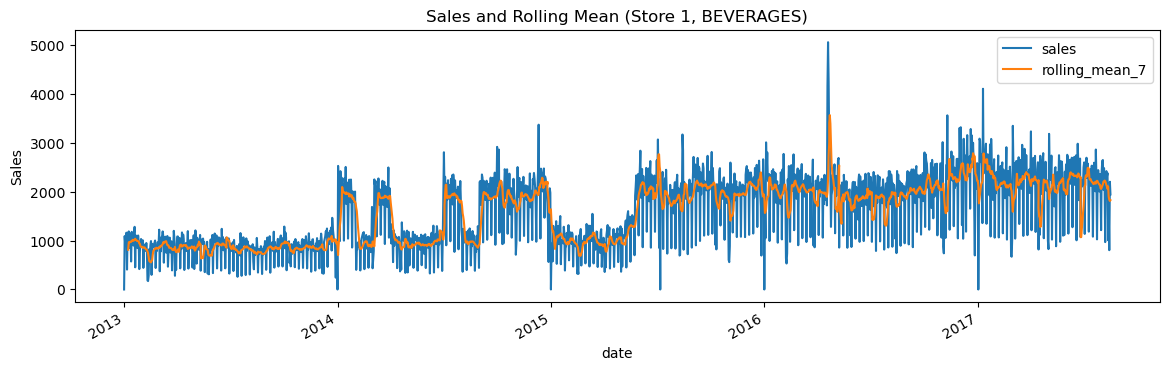

In [229]:
# Visualize rolling sales trend for one store/family
df_filtered = df[(df['store_nbr'] == 1) & (df['family'] == 'BEVERAGES')]
df_filtered.set_index('date')[['sales', 'rolling_mean_7']].plot(title='Sales and Rolling Mean (Store 1, BEVERAGES)', figsize=(14, 4))
plt.ylabel('Sales')
plt.show()

### 4. External data enrichment

#### Store addition

In [230]:
stores.rename(columns={'type': 'store_type'}, inplace=True)

In [231]:
# Merge store data
df = df.merge(stores, on='store_nbr', how='left')
df['type'] = df['type'].astype('category')
df['cluster'] = df['cluster'].astype('category')

df.dtypes[['type', 'cluster']]

type       category
cluster    category
dtype: object

#### Oil addition

In [232]:
oil['date'] = pd.to_datetime(oil['date'])

In [233]:
df = df.merge(oil, on='date', how='left')

In [234]:
# Forward-fill most of the series
# Backfill any remaining NaNs at the top (e.g. the first few days)
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

In [235]:
df = df.sort_values('date')
df['oil_lag_1'] = df[['dcoilwtico']].shift(1)
df['oil_rolling_7'] = df['dcoilwtico'].shift(1).rolling(7).mean()

In [236]:
df = df.dropna(subset=['oil_rolling_7','oil_lag_1'])

In [237]:
df[['date', 'dcoilwtico', 'oil_lag_1', 'oil_rolling_7']].head(10)

,date,dcoilwtico,oil_lag_1,oil_rolling_7
2242163,2013-01-01,47.57,47.57,54.08
2242162,2013-01-01,47.57,47.57,47.57
2242161,2013-01-01,47.57,47.57,47.57
2242160,2013-01-01,47.57,47.57,47.57
2242159,2013-01-01,47.57,47.57,47.57
2242158,2013-01-01,47.57,47.57,47.57
2242157,2013-01-01,47.57,47.57,47.57
2242156,2013-01-01,47.57,47.57,47.57
2242155,2013-01-01,47.57,47.57,47.57
2242154,2013-01-01,47.57,47.57,47.57


### 5. Train / Validation Split

In [238]:
cutoff_date = pd.to_datetime('2017-06-01')
train = df[df['date'] < cutoff_date]
valid = df[df['date'] >= cutoff_date]

In [239]:
FEATURES = [
    'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
    'rolling_mean_7', 'rolling_mean_14',
    'transactions_lag_1', 'transactions_lag_7',
    'transactions_rolling_7', 'transactions_rolling_14',
    'day_of_week', 'month', 'year', 'week_of_year',
    'days_since_start', 'is_weekend', 'is_new_year', 'is_december', 'is_holiday',
    'store_nbr', 'family', 'onpromotion', 'type', 'cluster',
    'oil_lag_1', 'oil_rolling_7'
]

X_train = train[FEATURES]
y_train = train['sales']
X_valid = valid[FEATURES]
y_valid = valid['sales']

X_train['store_nbr'] = X_train['store_nbr'].astype('category')
X_train['family'] = X_train['family'].astype('category')
X_valid['store_nbr'] = X_valid['store_nbr'].astype('category')
X_valid['family'] = X_valid['family'].astype('category')

/var/folders/0z/y41mdz4x1n131_s2cn_flnt80000gn/T/ipykernel_76387/1701288880.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['store_nbr'] = X_train['store_nbr'].astype('category')
/var/folders/0z/y41mdz4x1n131_s2cn_flnt80000gn/T/ipykernel_76387/1701288880.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['family'] = X_train['family'].astype('category')
/var/folders/0z/y41mdz4x1n131_s2cn_flnt80000gn/T/ipykernel_76387/1701288880.py:19: SettingWithCopyWarning: 
A value is trying to be se

### 6. Model Training

In [240]:
model = LGBMRegressor(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(50),
        log_evaluation(50)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3463
[LightGBM] [Info] Number of data points in the train set: 3031175, number of used features: 25
[LightGBM] [Info] Start training from score 354.145141
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 277.773	valid_0's l2: 77158.1
[100]	valid_0's rmse: 237.479	valid_0's l2: 56396.5
[150]	valid_0's rmse: 232.112	valid_0's l2: 53876.2
[200]	valid_0's rmse: 229.324	valid_0's l2: 52589.3
[250]	valid_0's rmse: 227.239	valid_0's l2: 51637.6
[300]	valid_0's rmse: 226.301	valid_0's l2: 51212.2
[350]	valid_0's rmse: 224.788	valid_0's l2: 50529.5
[400]	valid_0's rmse: 223.572	valid_0's l2: 49984.3
[450]	valid_0's rmse: 221.661	valid_0's l2: 49133.4
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              n_estimators=1000, random_state=42, subsample=0.8)

### 7. Feature Importance

In [241]:
y_pred = model.predict(X_valid)
rmsle = np.sqrt(mean_squared_log_error(y_valid.clip(0), y_pred.clip(0)))
print("Validation RMSLE:", rmsle)

Validation RMSLE: 0.5959605955963228


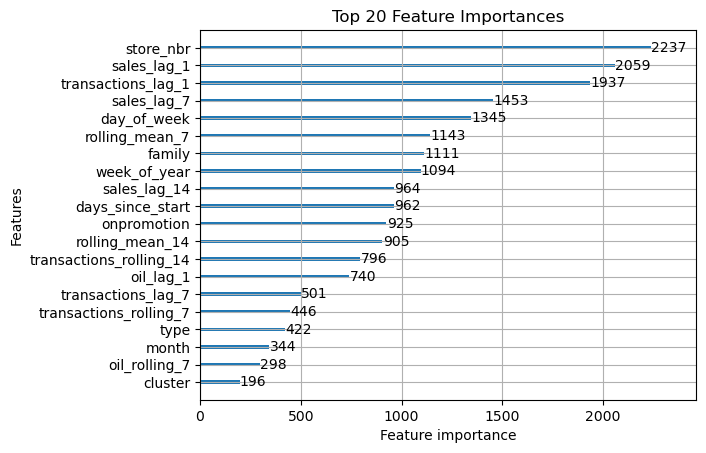

In [242]:
plot_importance(model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()

### 8. Generate Predictions

In [243]:
# Recreate test features before defining 'combined'
test['sales'] = np.nan

# Make sure 'test' only has the same columns as df
columns_to_add = [col for col in df.columns if col not in test.columns and col != 'sales']
for col in columns_to_add:
    test[col] = np.nan

# Combine while ensuring no duplicate index issues
combined = pd.concat([df, test], ignore_index=True)
combined = combined.reset_index(drop=True)
combined = combined.sort_values(['store_nbr', 'family', 'date'])

/var/folders/0z/y41mdz4x1n131_s2cn_flnt80000gn/T/ipykernel_76387/3470536355.py:10: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  combined = pd.concat([df, test], ignore_index=True)


In [244]:
# Recreate features for test
combined['sales_lag_1'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1)
combined['sales_lag_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(7)
combined['sales_lag_14'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(14)
combined['rolling_mean_7'] = combined.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
combined['rolling_mean_14'] = combined.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1).rolling(14).mean())

combined = combined.sort_values(['store_nbr', 'date'])
combined['transactions_lag_1'] = combined.groupby('store_nbr')['transactions'].shift(1)
combined['transactions_lag_7'] = combined.groupby('store_nbr')['transactions'].shift(7)
combined['transactions_rolling_7'] = combined.groupby('store_nbr')['transactions'].transform(lambda x: x.shift(1).rolling(7).mean())
combined['transactions_rolling_14'] = combined.groupby('store_nbr')['transactions'].transform(lambda x: x.shift(1).rolling(14).mean())

In [245]:
# Date features for test
combined['day_of_week'] = combined['date'].dt.dayofweek
combined['month'] = combined['date'].dt.month
combined['year'] = combined['date'].dt.year
combined['week_of_year'] = combined['date'].dt.isocalendar().week.astype(int)
combined['days_since_start'] = (combined['date'] - combined['date'].min()).dt.days
combined['is_weekend'] = combined['day_of_week'].isin([5, 6])
combined['is_december'] = combined['month'] == 12
combined['is_new_year'] = (combined['date'].dt.month == 1) & (combined['date'].dt.day == 1)
combined['is_holiday'] = combined['is_holiday'].astype(bool)
combined['onpromotion'] = combined['onpromotion'].astype(int)
combined['store_nbr'] = combined['store_nbr'].astype('category')
combined['family'] = combined['family'].astype('category')

In [246]:
# Generate predictions for test
X_test = combined[combined['sales'].isna()][FEATURES]
y_test_pred = model.predict(X_test)

submission = combined[combined['sales'].isna()][['id']].copy()
submission['sales'] = y_test_pred.clip(0)

# Ensure submission has unique IDs to prevent reindexing errors
submission = submission.drop_duplicates(subset='id')
assert submission['id'].is_unique, "Duplicate IDs found in submission!"

submission.to_csv('submission.csv', index=False)

### Final Model Summary
- **Validation RMSLE:** 0.59596
- **Model Type:** LightGBM Regressor